In [35]:
from fbprophet import Prophet
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import ElasticNet

In [36]:
stock_price_df = pd.read_csv('stock.csv')

In [37]:
stock_price_df = stock_price_df.sort_values(by = ['Date'])
stock_price_df.tail()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
2154,2020-08-05,440.250000,174.279999,29.850000,16.719999,3205.030029,125.449997,1485.020020,1473.609985,3327.770020
2155,2020-08-06,455.609985,172.199997,29.840000,18.459999,3225.000000,126.120003,1489.579956,1500.099976,3349.159912
2156,2020-08-07,444.450012,170.020004,30.020000,19.030001,3167.459961,124.959999,1452.709961,1494.489990,3351.280029
2157,2020-08-10,450.910004,179.410004,30.200001,21.650000,3148.159912,127.110001,1418.569946,1496.099976,3360.469971
2158,2020-08-11,437.500000,180.130005,30.200001,21.500000,3080.669922,126.750000,1374.390015,1480.319946,3333.689941


In [38]:
# Function to concatenate the date, stock price, and volume in one dataframe
def individual_stock(price_df, name):
    return pd.DataFrame({'Date': price_df['Date'], 'Close': price_df[name]})

In [39]:
# Let's test the functions and get individual stock prices for AAPL
#AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
stock_name='AAPL'
price_df = individual_stock(stock_price_df, stock_name)
price_df.head(7)

,Date,Close
0,2012-01-12,60.198570
1,2012-01-13,59.972858
2,2012-01-17,60.671429
3,2012-01-18,61.301430
4,2012-01-19,61.107143
5,2012-01-20,60.042858
6,2012-01-23,61.058571


### Short Term Forecasting (7 days) using Elastic Net

In [40]:
price_elastic=price_df.copy()
price_elastic['Lag1'] = price_elastic[['Close']].shift(1)
price_elastic['Lag2'] = price_elastic[['Close']].shift(2)
price_elastic['Lag3'] = price_elastic[['Close']].shift(3)
price_elastic['Lag4'] = price_elastic[['Close']].shift(4)
price_elastic['Lag5'] = price_elastic[['Close']].shift(5)
price_elastic['Lag6'] = price_elastic[['Close']].shift(6)
price_elastic['Lag7'] = price_elastic[['Close']].shift(7)
price_elastic.Date = pd.DatetimeIndex(price_elastic.Date)
#         individual_ts[i].index=individual_ts[i].ds     
price_elastic.set_index('Date', inplace=True)
price_elastic = price_elastic.dropna()

In [41]:
price_elastic.head()

,Close,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7
Date,,,,,,,,
2012-01-24,60.058571,61.058571,60.042858,61.107143,61.301430,60.671429,59.972858,60.198570
2012-01-25,63.808571,60.058571,61.058571,60.042858,61.107143,61.301430,60.671429,59.972858
2012-01-26,63.518570,63.808571,60.058571,61.058571,60.042858,61.107143,61.301430,60.671429
2012-01-27,63.897144,63.518570,63.808571,60.058571,61.058571,60.042858,61.107143,61.301430
2012-01-30,64.715714,63.897144,63.518570,63.808571,60.058571,61.058571,60.042858,61.107143


In [42]:
price_elastic_train=price_elastic.iloc[:-7,:]
price_elastic_test=price_elastic.iloc[-7:,:]

In [43]:
x_train=price_elastic_train.drop(["Close"],1)
y_train=price_elastic_train["Close"]
x_test=price_elastic_test.drop(["Close"],1)
y_test=price_elastic_test["Close"]
en_reg = ElasticNet(random_state=0)
en_reg.fit(x_train,y_train)
predicted_test=en_reg.predict(x_test)

In [45]:
print(predicted_test)

[419.01237917 434.54788517 438.81447309 440.55541119 453.60839844
 446.95198265 450.83005701]


In [53]:
df_predicted=pd.DataFrame()
df_predicted['Date']=price_elastic_test.index
df_predicted['Real']=list(price_elastic_test['Close'])
df_predicted['Predicted']=predicted_test
df_predicted.set_index('Date', inplace=True)

In [54]:
df_predicted

,Real,Predicted
Date,,
2020-08-03,435.750000,419.012379
2020-08-04,438.660004,434.547885
2020-08-05,440.250000,438.814473
2020-08-06,455.609985,440.555411
2020-08-07,444.450012,453.608398
2020-08-10,450.910004,446.951983
2020-08-11,437.500000,450.830057


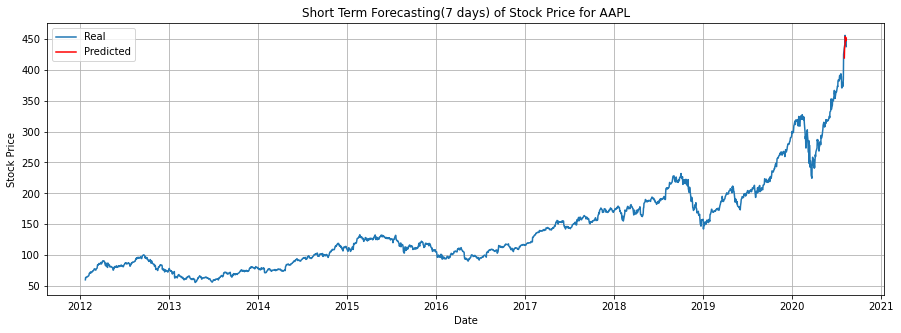

In [66]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.title('Short Term Forecasting(7 days) of Stock Price for '+stock_name)
plt.plot(price_elastic.Close,label="Real")
plt.plot(df_predicted.Predicted,label="Predicted",color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid()
plt.legend(loc="best")
plt.show()

### Long Term Forecasting using Prophet(14 days)

In [6]:
price_prophet=pd.DataFrame()
price_prophet['ds']=price_df['Date']
price_prophet['y']=price_df['Close']
price_prophet_train=price_prophet.iloc[:-14,:]
price_prophet_test=price_prophet.iloc[-14:,:]

In [7]:
price_prophet_train.tail()

,ds,y
2140,2020-07-16,386.089996
2141,2020-07-17,385.309998
2142,2020-07-20,393.429993
2143,2020-07-21,388.000000
2144,2020-07-22,389.089996


In [71]:
price_prophet_test

,ds,y
2145,2020-07-23,371.380005
2146,2020-07-24,370.459991
2147,2020-07-27,379.239990
2148,2020-07-28,373.010010
2149,2020-07-29,380.160004
2150,2020-07-30,384.760010
2151,2020-07-31,425.040009
2152,2020-08-03,435.750000
2153,2020-08-04,438.660004
2154,2020-08-05,440.250000


In [8]:
model=Prophet(daily_seasonality=True,yearly_seasonality=False)

In [9]:
model.fit(price_prophet_train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [10]:
future = model.make_future_dataframe(periods=14)

In [11]:
forecast=model.predict(future)

In [74]:

print("Forecasted Table for 14 days stock price prediction for "+stock_name)
Forecast=pd.DataFrame()
Forecast['Day']=forecast['ds']
Forecast['Forecasted stock price']=[round(x,2) for x in list(forecast['yhat'])]
Forecast['Lower Limit']=[round(x,2) for x in list(forecast['yhat_lower'])]
Forecast['Upper Limit']=[round(x,2) for x in list(forecast['yhat_upper'])]
Forecast.set_index('Day',inplace=True)
print(Forecast.tail(14))

Forecasted Table for 14 days stock price prediction for AAPL
            Forecasted stock price  Lower Limit  Upper Limit
Day                                                         
2020-07-23                  324.14       304.05       343.33
2020-07-24                  324.16       304.95       343.17
2020-07-25                  322.56       303.74       341.46
2020-07-26                  322.81       302.55       342.58
2020-07-27                  325.08       306.18       343.50
2020-07-28                  325.60       306.00       344.23
2020-07-29                  325.95       307.13       345.21
2020-07-30                  325.93       306.47       345.29
2020-07-31                  325.95       308.00       345.76
2020-08-01                  324.34       305.66       343.46
2020-08-02                  324.60       305.69       342.63
2020-08-03                  326.86       307.66       346.61
2020-08-04                  327.39       307.83       347.54
2020-08-05              

Long Term forecasting(14 days) of stock price for AAPL


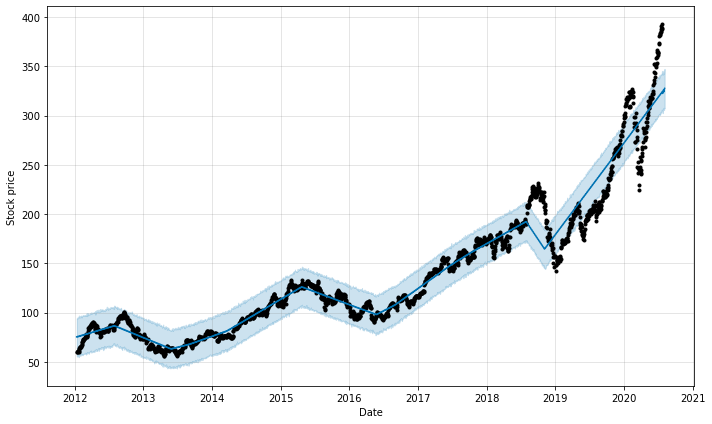

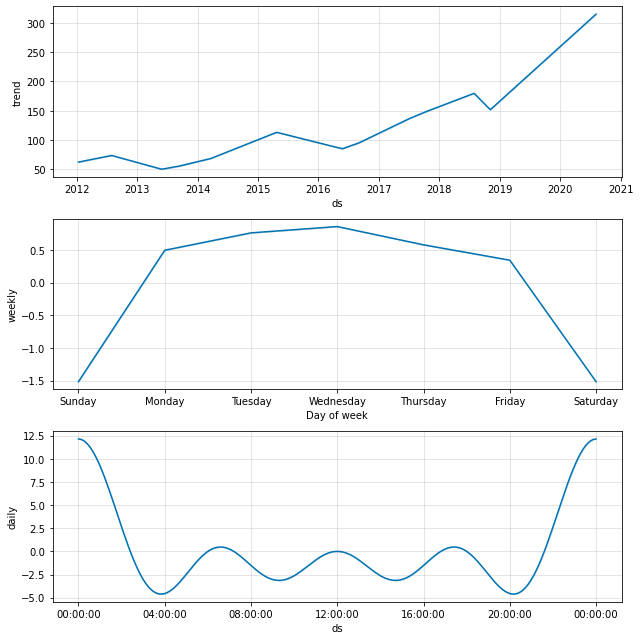

In [68]:
print("Long Term forecasting(14 days) of stock price for "+stock_name)
model.plot(forecast,xlabel="Date",ylabel="Stock price")
model.plot_components(forecast);